### Toulouse/Squidguard Model


In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np.random.seed(1)
tf.random.set_seed(2)

NGRAMS = 2
FEATURE_LEN = 128
EPOCHS = 5

# Blacklists
df = pd.read_csv('../train-test/data/blacklists.csv.bz2')
df


,domain,blacklists_cat
0,59.52.114.68,phishing
1,eroticalee1.blogspot.ru,adult
2,jstanothergrly.blogspot.com.br,adult
3,youmightbest.tk,redirector|strict_redirector|strong_redirector
4,jstanothergrly.blogspot.com.by,adult
...,...,...
2140116,aqnjmquscyduyhw.blogspot.com.ng,adult
2140117,sexyhotmalemodels.blogspot.ug,adult
2140118,sex-in-sydney.blogspot.com.cy,adult
2140119,ipornx.blogspot.pe,adult


In [2]:
df['cat_count'] = df.blacklists_cat.apply(lambda c: len(c.split('|')))
sdf = df[df.cat_count == 1]
sdf

,domain,blacklists_cat,cat_count
0,59.52.114.68,phishing,1
1,eroticalee1.blogspot.ru,adult,1
2,jstanothergrly.blogspot.com.br,adult,1
4,jstanothergrly.blogspot.com.by,adult,1
5,edwardmax1.blogspot.com.au,adult,1
...,...,...,...
2140116,aqnjmquscyduyhw.blogspot.com.ng,adult,1
2140117,sexyhotmalemodels.blogspot.ug,adult,1
2140118,sex-in-sydney.blogspot.com.cy,adult,1
2140119,ipornx.blogspot.pe,adult,1


In [3]:
dom_group = sdf.groupby('blacklists_cat').agg({'domain': 'count'})
dom_group

,domain
blacklists_cat,
adult,1870741
agressif,304
arjel,11
associations_religieuses,1
astrology,27
audio-video,2977
bank,1689
bitcoin,251
blog,1425


### Take out categories that have less than 1000 domains.

In [4]:
filter_cat = list(dom_group[dom_group.domain > 1000].index)

### Take out categories that have recall < 0.3 (based on previous iterations of the model)

In [5]:
excat = ['audio-video', 'blog', 'dating', 'liste_bu', 'sports', 'publicite']

In [6]:
filter_cat = [x for x in filter_cat if x not in excat]
filter_cat

['adult',
 'bank',
 'gambling',
 'games',
 'malware',
 'phishing',
 'press',
 'shopping']

In [7]:
sdf.loc[sdf.blacklists_cat.isin(filter_cat) == False, 'blacklists_cat'] = 'others'

/opt/venv37/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
sdf.groupby('blacklists_cat').agg({'domain': 'count'})

,domain
blacklists_cat,
adult,1870741
bank,1689
gambling,1012
games,9357
malware,4463
others,21441
phishing,62712
press,4410
shopping,36331


## Preprocessing the input data

In [9]:
# build n-gram list
#vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
vect = CountVectorizer(analyzer='char', ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(sdf.domain)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.domain.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

num_words = 1498


In [10]:
print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
class_labels = sdf.blacklists_cat.astype('category').cat.categories
y = np.array(sdf.blacklists_cat.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
#X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# backup
y_train_lab = y_train
y_test_lab = y_test

Max feature len = 137, Avg. feature len = 23


In [11]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 374149,
 1: 338,
 2: 202,
 3: 1871,
 4: 893,
 5: 4288,
 6: 12543,
 7: 882,
 8: 7266}

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 1496592,
 1: 1351,
 2: 810,
 3: 7486,
 4: 3570,
 5: 17153,
 6: 50169,
 7: 3528,
 8: 29065}

## Train a LSTM model

In [13]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = FEATURE_LEN # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

n_classes = np.max(y_train) + 1
print(n_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


1609724 train sequences
402432 test sequences
Pad sequences (samples x time)
X_train shape: (1609724, 128)
X_test shape: (402432, 128)
9 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (1609724, 9)
y_test shape: (402432, 9)


In [14]:
print('Build model...')

model = Sequential()
model.add(Embedding(num_words, 32, input_length=feature_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           47936     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 131,529
Trainable params: 131,529
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,
          validation_split=0.1, verbose=1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Train...


/opt/venv37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1448751 samples, validate on 160973 samples
Epoch 1/5
1448751/1448751 [==============================] - 6577s 5ms/step - loss: 0.1716 - accuracy: 0.9446 - val_loss: 0.1491 - val_accuracy: 0.9505
Epoch 2/5
1448751/1448751 [==============================] - 6358s 4ms/step - loss: 0.1447 - accuracy: 0.9520 - val_loss: 0.1388 - val_accuracy: 0.9536
Epoch 3/5
1448751/1448751 [==============================] - 6430s 4ms/step - loss: 0.1379 - accuracy: 0.9540 - val_loss: 0.1336 - val_accuracy: 0.9553
Epoch 4/5
1448751/1448751 [==============================] - 6461s 4ms/step - loss: 0.1347 - accuracy: 0.9550 - val_loss: 0.1306 - val_accuracy: 0.9563
Epoch 5/5
402432/402432 [==============================] - 525s 1ms/step
Test score: 0.12929992485736122
Test accuracy: 0.9566435813903809


## Confusion Matrix

In [16]:
y_pred = model.predict_classes(X_test, verbose=1)
p = model.predict_proba(X_test, verbose=2) # to predict probability
target_names = list(sdf.blacklists_cat.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

402432/402432 [==============================] - 520s 1ms/step
              precision    recall  f1-score   support

       adult       0.97      0.99      0.98    374149
        bank       0.68      0.56      0.61       338
    gambling       0.49      0.18      0.27       202
       games       0.84      0.45      0.58      1871
     malware       0.97      0.48      0.64       893
      others       0.60      0.19      0.28      4288
    phishing       0.72      0.60      0.65     12543
       press       0.78      0.53      0.63       882
    shopping       0.67      0.44      0.53      7266

    accuracy                           0.96    402432
   macro avg       0.75      0.49      0.58    402432
weighted avg       0.95      0.96      0.95    402432

[[371508     22     18     80      7    272   1401     45    796]
 [    65    190      0      0      0     22     47      1     13]
 [   121      0     37      5      0      4     24      1     10]
 [   780      3      1    836     

## Save model

In [17]:
model.save('./models/toulouse_cat_lstm_others_2017.h5')
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('./models/toulouse_cat_vocab_others_2017.csv', index=False, encoding='utf-8')
pd.DataFrame(target_names, columns=['toulouse_cat']).to_csv('./models/toulouse_cat_names_others_2017.csv', index=False)

In [18]:
y_score = model.predict(X_test, verbose=1)
y_score

402432/402432 [==============================] - 522s 1ms/step


array([[9.9999845e-01, 3.7797006e-09, 7.3609608e-13, ..., 1.5146185e-07,
        1.2925631e-10, 2.8310282e-08],
       [9.9999225e-01, 1.5225542e-07, 5.5207553e-12, ..., 3.1811777e-07,
        8.4683558e-09, 1.0198133e-06],
       [9.9999905e-01, 7.1547401e-10, 6.7293172e-12, ..., 2.5907340e-08,
        4.8330086e-11, 2.1916692e-07],
       ...,
       [9.9999785e-01, 4.6977773e-09, 4.2002854e-10, ..., 7.3587188e-07,
        1.7778319e-09, 2.8923489e-07],
       [9.5459700e-01, 1.6949090e-05, 6.0949467e-05, ..., 8.2625849e-03,
        3.5716908e-05, 6.9232925e-04],
       [9.9999833e-01, 5.0919904e-11, 7.5938837e-13, ..., 1.5533280e-07,
        6.6282578e-12, 3.5721512e-09]], dtype=float32)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


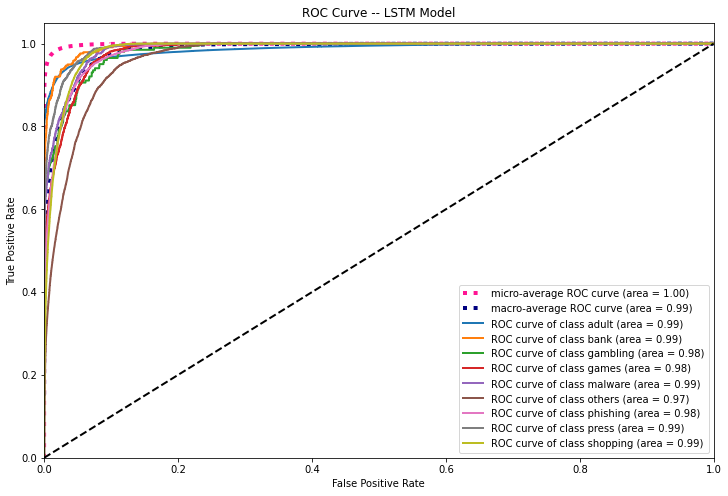

In [19]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab10")
colors = cycle([cmap(i) for i in range(n_classes)])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
    if i >= 19:
        break

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- LSTM Model')
plt.legend(loc="lower right")
plt.show()